<a href="https://colab.research.google.com/github/airballoh87/bexa/blob/main/Painted_Tree_sales_ML_Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()

In [ ]:
##data and stats
import pandas as pd
import seaborn as sns

##visualis
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # Import the ticker module

##data sources
import gspread
from google.colab import drive

##web scraping
import requests
from bs4 import BeautifulSoup

##machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

##NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk

##saving models
import joblib

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Get data

##For training

In [ ]:
gc  = gspread.authorize(creds)

# Function to read data from a Google Sheet and add a store location column
def read_sheet(url, worksheet_name, location):
    gsheets = gc.open_by_url(url)
    sheets = gsheets.worksheet(worksheet_name).get_all_values()
    df = pd.DataFrame(sheets[1:], columns=sheets[0])
    df['store_location'] = location
    return df

# URLs and worksheet names
kentucky_url = 'https://docs.google.com/spreadsheets/d/117PfZR2st0KhQ1L4t3GuNL7vsj2CYq6MDJhMm-cr6N4/edit?gid=427915297#gid=427915297'
cincinnati_url = 'https://docs.google.com/spreadsheets/d/1r_xXGRpcoegezaQTwpoOXhgaWpbHZIJYDoVnygquSGQ'
kentucky_sheet = 'Consignor Access - Activity (10)'
cincinnati_sheet = 'Consignor Access - Activity (11)'

# Read data from both sheets
kentucky_data = read_sheet(kentucky_url, kentucky_sheet, 'Kentucky')
cincinnati_data = read_sheet(cincinnati_url, cincinnati_sheet, 'Cincinnati')

# Combine the data into one DataFrame
combined_historical_data = pd.concat([kentucky_data, cincinnati_data], ignore_index=True)

# Filter out rows where 'Retail Price' is NA, NULL, or an empty string
combined_historical_data = combined_historical_data[combined_historical_data['Retail Price'].notna() & (combined_historical_data['Retail Price'] != '')]

# Remove rows where 'Category' is NA, NULL, or an empty string
combined_historical_data = combined_historical_data.dropna(subset=['Category'])
combined_historical_data = combined_historical_data[combined_historical_data['Category'] != '']

# Filter out rows where 'Retail Price' has a value of 'Retail Price'
combined_historical_data = combined_historical_data[combined_historical_data['Retail Price'] != 'Retail Price']

# Display the first few rows and get the column names and data types
print(combined_historical_data.info())
print(combined_historical_data.head())


#Clean Data

## rows and columns - general

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import joblib


# Load the dataset
new_sales_data = combined_historical_data

# Clean and convert price columns to numerical values
def clean_price(price):
    if isinstance(price, str):
        price = price.replace('(', '').replace(')', '').replace('$', '').replace(',', '')
        try:
            return float(price)
        except ValueError:
            return None
    return price

new_sales_data['Retail Price'] = new_sales_data['Retail Price'].apply(clean_price)
new_sales_data['Sold Price'] = new_sales_data['Sold Price'].apply(clean_price)
new_sales_data['Store Amount'] = new_sales_data['Store Amount'].apply(clean_price)
new_sales_data['Consignor Amount'] = new_sales_data['Consignor Amount'].apply(clean_price)

# Drop rows with missing values in the target column 'Category'
new_sales_data = new_sales_data.dropna(subset=['Category'])

#Eliminates historical rows where the was a return
new_sales_data = new_sales_data[(new_sales_data['Sold Price'] >= 0) #&
                                #(new_sales_data['Store Amount'] >= 0) &
                                #(new_sales_data['Consignor Amount'] >= 0)
                                ]


# Clean up the 'Category' column
new_sales_data['Category'] = new_sales_data['Category'].str.upper()

# Make specified updates to the 'Category' column
category_updates = {
    'MISC': 'MISCELLANEOUS',
    'SHELL': 'DECOR',
    'CLOTHES': 'CLOTHING',
    'HAT': 'HATS',
    'APPAREL': 'CLOTHING',
    'DECOR - EASTER': 'DECOR',
    'DECOR - VALENTINES': 'DECOR',
    'DOGS': 'PET',
    'HAIR ACCESSORIES': 'ACCESSORIES: HAIR',
    'HOLIDAY - EASTER': 'DECOR',
    'HOLIDAY DECOR - EASTER': 'DECOR',
    'HOME KITCHEN': 'HOME',
    'KIDS': 'KIDS ACCESSORIES',
    'KIDS APPAREL': 'KIDS CLOTHING',
    'KIDS HAIR': 'KIDS ACCESSORIES',
    'KIDS HAT': 'KIDS ACCESSORIES',
    'KIDS HATS': 'KIDS ACCESSORIES',
    'KIDS JEWELRY': 'KIDS ACCESSORIES'
}

new_sales_data['Category'] = new_sales_data['Category'].replace(category_updates)

# Drop columns 'Type' and 'Theme' as they will not be used for prediction
new_sales_data = new_sales_data.drop(columns=['Type', 'Theme'])

new_sales_data

#Train Data - Item 'Category'


## first pass on random forest model

In [ ]:
# Vectorize the 'Description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Description'])

# Create a DataFrame from the TF-IDF features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add other numerical features to the TF-IDF DataFrame
X = pd.concat([X_tfidf_df, data_cleaned[['Retail Price', 'Sold Price']].reset_index(drop=True)], axis=1)

# Encode the target variable 'Category'
y = data_cleaned['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

accuracy_rf, report_rf

##NLP and tuning on Description field as input to prediction variable

In [ ]:
from sklearn.model_selection import GridSearchCV

# Vectorize the 'Description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Description'])

# Create a DataFrame from the TF-IDF features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add other numerical features to the TF-IDF DataFrame
X = pd.concat([X_tfidf_df, data_cleaned[['Retail Price', 'Sold Price']].reset_index(drop=True)], axis=1)

# Encode the target variable 'Category'
y = data_cleaned['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Initialize the GridSearchCV with Random Forest model
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the best model with best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the model's performance
best_accuracy = accuracy_score(y_test, y_pred_best)
best_report = classification_report(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Test Set Accuracy:", best_accuracy)
print("Classification Report:\n", best_report)

## best parameters for hyper tuning


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Apply preprocessing to the 'Description' column
data_cleaned['Description'] = data_cleaned['Description'].apply(preprocess_text)

# Define a TF-IDF vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(max_features=500, max_df=0.95, min_df=5, ngram_range=(1, 2))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['Description'], data_cleaned['Category'], test_size=0.2, random_state=42)

# Define a pipeline with TF-IDF vectorizer and Random Forest classifier
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_df': [0.85, 0.9, 0.95],
    'tfidf__min_df': [3, 5, 7],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Add the predictions and prediction probabilities to the original DataFrame
data_cleaned['Predicted_Category'] = grid_search.predict(data_cleaned['Description'])
pred_probabilities = grid_search.predict_proba(data_cleaned['Description'])
max_probabilities = pred_probabilities.max(axis=1)
data_cleaned['Category_prediction_probability'] = max_probabilities

# Display the first 20 rows of the output
print(data_cleaned[['Description', 'Predicted_Category', 'Category_prediction_probability']].head(20))


##run with Best NLP parameters

In [ ]:
# Vectorize the 'Description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Description'])

# Create a DataFrame from the TF-IDF features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add other numerical features to the TF-IDF DataFrame
X = pd.concat([X_tfidf_df, data_cleaned[['Retail Price', 'Sold Price']].reset_index(drop=True)], axis=1)

# Encode the target variable 'Category'
y = data_cleaned['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the best parameters found by GridSearchCV
best_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Initialize the Random Forest model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)

# Train the model
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the model's performance
best_accuracy = accuracy_score(y_test, y_pred_best)
best_report = classification_report(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("Test Set Accuracy:", best_accuracy)
print("Classification Report:\n", best_report)

##best feature chart

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame for the feature importances
feature_names = X.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.set(style='darkgrid')
plt.style.use('dark_background')
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20), palette='Blues_r')
plt.title('Top 20 Feature Importances in Random Forest Model', color='black')
plt.xlabel('Importance', color='black')
plt.ylabel('Feature', color='black')

# Customize the appearance of the plot
ax.tick_params(colors='black')  # Set color of the tick labels
ax.yaxis.label.set_color('black')  # Set the y-axis label color
ax.xaxis.label.set_color('black')  # Set the x-axis label color
plt.setp(ax.get_xticklabels(), color='black')  # Set x-tick labels color
plt.setp(ax.get_yticklabels(), color='black')  # Set y-tick labels color
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.show()


## writing model to local drive


In [ ]:
## writing model to local drive

from google.colab import drive
drive.mount('/content/drive')

import joblib

# Assuming tfidf_vectorizer is the vectorizer used during model training
joblib.dump(tfidf_vectorizer, '/content/drive/My Drive/Bexa/tfidf_vectorizer_item_category.pkl')

##load the file - for use later

In [ ]:
##load the file - for use later
import joblib

# Load the saved TF-IDF vectorizer
tfidf_vectorizer = joblib.load('/content/drive/My Drive/Bexa/tfidf_vectorizer_item_category.pkl')


## run with optimized paramters - writing best model to outputs

In [ ]:
## run with optimized paramters - writing best model to outputs

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Mount Google Drive
drive.mount('/content/drive')

# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)


# Apply preprocessing to the 'Description' column
data_cleaned['Description'] = data_cleaned['Description'].apply(preprocess_text)

# Load the saved TF-IDF vectorizer
tfidf_vectorizer = joblib.load('/content/drive/My Drive/Bexa/tfidf_vectorizer_item_category.pkl')

# Define the Random Forest classifier with the optimized parameters
rf_classifier = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=100, random_state=42)

# Define the pipeline with the optimized parameters
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', rf_classifier)
])

# Fit the pipeline with the training data (if you have a training set)
# Split the data into training and testing sets (update this if you have training data available)
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['Description'], data_cleaned['Category'], test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# Save the pipeline to Google Drive
joblib.dump(pipeline,'/content/drive/My Drive/Bexa/best_model_category.pkl')


# Load the pipeline (if needed)
pipeline = joblib.load('/content/drive/My Drive/Bexa/best_model_category.pkl')

# Transform the 'Description' column using the fitted TF-IDF vectorizer
X_accumulated_tfidf = tfidf_vectorizer.transform(data_cleaned['Description'])

# Make predictions on the new data
data_cleaned['Predicted_Category'] = pipeline.predict(data_cleaned['Description'])

# Calculate prediction probabilities
pred_probabilities = pipeline.predict_proba(data_cleaned['Description'])

# Get the maximum probability for each prediction
max_probabilities = pred_probabilities.max(axis=1)

# Add the probabilities to the DataFrame
data_cleaned['Category_prediction_probability'] = max_probabilities

# Display the first 20 rows of the output with the new predicted_category and probability columns
print(data_cleaned[['Description', 'Predicted_Category', 'Category_prediction_probability']].head(20))


##write to file on google sheets

In [ ]:
##write to file on google sheets

# Assuming 'y_train' is a Series, convert it to a DataFrame for easier handling
data_cleaned = data_cleaned.astype(str)

# Convert the DataFrame to a list of lists
data = [data_cleaned.columns.values.tolist()] + data_cleaned.values.tolist()

# Create a new Google Sheet or open an existing one
spreadsheet_name = 'painted_tree_ml_training'
worksheet_name = 'Painted Tree - Training Model input - with Category'

# Try to open the existing spreadsheet
try:
    spreadsheet = gc.open(spreadsheet_name)
except gspread.SpreadsheetNotFound:
    spreadsheet = gc.create(spreadsheet_name)

# Check if the worksheet already exists and delete it if it does
try:
    worksheet = spreadsheet.worksheet(worksheet_name)
    spreadsheet.del_worksheet(worksheet)
except gspread.WorksheetNotFound:
    pass

# Add a new worksheet
worksheet = spreadsheet.add_worksheet(title=worksheet_name, rows=len(data_cleaned)+1, cols=len(data_cleaned.columns))
#worksheet = spreadsheet.add_worksheet(title=worksheet_name, rows=len(y_train_df)+1, cols=len(y_train_df.columns))

# Write data to the worksheet
worksheet.update('A1', data)


#Train Data - Item 'Type'

##get data from training on type - needs to have 'Category Run'

In [ ]:
#gc  = gspread.authorize(creds)

# Function to read data from a Google Sheet and add a store location column
#def read_sheet_all(url, worksheet_name):
    #gsheets = gc.open_by_url(url)
    #sheets = gsheets.worksheet(worksheet_name).get_all_values()
    #df = pd.DataFrame(sheets[1:], columns=sheets[0])
    #return df

# URLs and worksheet names
#items_with_category_url = 'https://docs.google.com/spreadsheets/d/1gzZ4ffnM5Uc4cCHmAigMQ4IS3xxVokBc1wM5tQjPQcM/edit?gid=1475868757#gid=1475868757'
#items_with_category_sheet = 'Painted Tree - Training Model input - with Category'

# Read data from both sheets
#items_with_category_data = read_sheet_all(items_with_category_url, items_with_category_sheet)


# Filter out rows where 'Retail Price' is NA, NULL, or an empty string
#items_with_category_data = items_with_category_data[items_with_category_data['Retail Price'].notna() & (items_with_category_data['Retail Price'] != '')]

# Remove rows where 'Category' is NA, NULL, or an empty string
#items_with_category_data = items_with_category_data.dropna(subset=['Category'])
#items_with_category_data = items_with_category_data[items_with_category_data['Category'] != '']

# Filter out rows where 'Retail Price' has a value of 'Retail Price'
#items_with_category_data = items_with_category_data[items_with_category_data['Retail Price'] != 'Retail Price']

# Display the first few rows and get the column names and data types
#print(items_with_category_data.info())
#print(items_with_category_data.head())

In [ ]:
gc  = gspread.authorize(creds)

# Function to read data from a Google Sheet and add a store location column
def read_sheet(url, worksheet_name, location):
    gsheets = gc.open_by_url(url)
    sheets = gsheets.worksheet(worksheet_name).get_all_values()
    df = pd.DataFrame(sheets[1:], columns=sheets[0])
    df['store_location'] = location
    return df

# URLs and worksheet names
kentucky_url = 'https://docs.google.com/spreadsheets/d/117PfZR2st0KhQ1L4t3GuNL7vsj2CYq6MDJhMm-cr6N4/edit?gid=427915297#gid=427915297'
cincinnati_url = 'https://docs.google.com/spreadsheets/d/1r_xXGRpcoegezaQTwpoOXhgaWpbHZIJYDoVnygquSGQ'
kentucky_sheet = 'Consignor Access - Activity (10)'
cincinnati_sheet = 'Consignor Access - Activity (11)'

# Read data from both sheets
kentucky_data = read_sheet(kentucky_url, kentucky_sheet, 'Kentucky')
cincinnati_data = read_sheet(cincinnati_url, cincinnati_sheet, 'Cincinnati')

# Combine the data into one DataFrame
combined_historical_data = pd.concat([kentucky_data, cincinnati_data], ignore_index=True)

# Filter out rows where 'Retail Price' is NA, NULL, or an empty string
combined_historical_data = combined_historical_data[combined_historical_data['Retail Price'].notna() & (combined_historical_data['Retail Price'] != '')]

# Remove rows where 'Category' is NA, NULL, or an empty string
combined_historical_data = combined_historical_data.dropna(subset=['Category'])
combined_historical_data = combined_historical_data[combined_historical_data['Category'] != '']

# Filter out rows where 'Retail Price' has a value of 'Retail Price'
combined_historical_data = combined_historical_data[combined_historical_data['Retail Price'] != 'Retail Price']

# Display the first few rows and get the column names and data types
print(combined_historical_data.info())
print(combined_historical_data.head())


## Clean Data


In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import joblib


# Load the dataset
new_sales_data = combined_historical_data

# Clean and convert price columns to numerical values
def clean_price(price):
    if isinstance(price, str):
        price = price.replace('(', '').replace(')', '').replace('$', '').replace(',', '')
        try:
            return float(price)
        except ValueError:
            return None
    return price

new_sales_data['Retail Price'] = new_sales_data['Retail Price'].apply(clean_price)
new_sales_data['Sold Price'] = new_sales_data['Sold Price'].apply(clean_price)
new_sales_data['Store Amount'] = new_sales_data['Store Amount'].apply(clean_price)
new_sales_data['Consignor Amount'] = new_sales_data['Consignor Amount'].apply(clean_price)

# Drop rows with missing values in the target column 'Category', 'Type'
new_sales_data = new_sales_data.dropna(subset=['Category'])
new_sales_data = new_sales_data.dropna(subset=['Type'])

#Eliminates historical rows where the was a return
new_sales_data = new_sales_data[(new_sales_data['Sold Price'] >= 0) #&
                                #(new_sales_data['Store Amount'] >= 0) &
                                #(new_sales_data['Consignor Amount'] >= 0)
                                ]


# Clean up the 'Category' column
new_sales_data['Category'] = new_sales_data['Category'].str.upper()
new_sales_data['Type'] = new_sales_data['Type'].str.upper()
# Make specified updates to the 'Category' column
category_updates = {
    'MISC': 'MISCELLANEOUS',
    'SHELL': 'DECOR',
    'CLOTHES': 'CLOTHING',
    'HAT': 'HATS',
    'APPAREL': 'CLOTHING',
    'DECOR - EASTER': 'DECOR',
    'DECOR - VALENTINES': 'DECOR',
    'DOGS': 'PET',
    'HAIR ACCESSORIES': 'ACCESSORIES: HAIR',
    'HOLIDAY - EASTER': 'DECOR',
    'HOLIDAY DECOR - EASTER': 'DECOR',
    'HOME KITCHEN': 'HOME',
    'KIDS': 'KIDS ACCESSORIES',
    'KIDS APPAREL': 'KIDS CLOTHING',
    'KIDS HAIR': 'KIDS ACCESSORIES',
    'KIDS HAT': 'KIDS ACCESSORIES',
    'KIDS HATS': 'KIDS ACCESSORIES',
    'KIDS JEWELRY': 'KIDS ACCESSORIES'
}

type_updates = {
    'BUNNY': 'BUNNY DECOR',
    'COAT': 'JACKET',
    'COVER UP': 'COVERUP',
    'COWBOY HAT': 'COWBOY',
    'COWBOY HAT DECOR': 'COWBOY',
    'DOG COLLAR LARGE': 'DOG COLLAR',
    'DOG COLLAR MEDIUM': 'DOG COLLAR',
    'DOG COLLAR SMALL' : 'DOG COLLAR',
    'EAR MUFFS': 'EARMUFFS',
    'HAIR CLIP': 'HAIR CLIPS',
    'KEY CHAIN': 'KEYCHAIN',
    'ORNAMENT': 'ORNAMENTS',
    'WINTER HAT': 'WINTER',
    'WINE TUMBLER': 'TUMBLER',
    'TOTE': 'TOTE BAG',
    'SWIM': 'SWIMWEAR',
    'RING': 'RINGS',
    'BEADED NECKLACE': 'NECKLACE',
    'BOTTLE OPENER':'MISCELLANEOUS' ,
    'SPPONS': 'SPOONS',
    'SPOON HOLDER':'SPOONS'

}


new_sales_data['Category'] = new_sales_data['Category'].replace(category_updates)
new_sales_data['Type'] = new_sales_data['Type'].replace(type_updates)

# Drop columns 'Type' and 'Theme' as they will not be used for prediction
data_cleaned = new_sales_data.drop(columns=[ 'Theme'])

data_cleaned

,Date,Description,SKU,Invoice,Category,Type,Retail Price,Sold Price,Store Amount,Consignor Amount,store_location
0,4/6/2024,100% leather mini zip short wallet:(2-01445),9LN7ZA,35046,BAGS,WALLET,22.0,22.0,-2.2,19.8,Kentucky
1,4/10/2024,11 - PREMIUM -Crystal Rivoli Stone 12MM Bracel...,DP195G,36197,JEWELRY,BRACELET,45.0,45.0,-4.5,40.5,Kentucky
2,1/24/2024,12pcs - ribbon colorful rhinestone layered str...,S16CP9,8913,JEWELRY,BRACELET,25.0,25.0,-2.5,22.5,Kentucky
3,4/10/2024,14-Crystal Rivoli Stone 8MM Bracelet - RB Hand...,5YKL69,36197,JEWELRY,BRACELET,30.0,30.0,-3.0,27.0,Kentucky
4,5/4/2024,1989 Taylor Swift 16oz Frosted Libbey Glass Tu...,N4NG5L,42414,HOME,GLASS TUMBLER,26.0,26.0,-2.6,23.4,Kentucky
...,...,...,...,...,...,...,...,...,...,...,...
4296,3/28/2023,yellow rhinestone top knot headband:(2-00471),UZ4DXL,2056,ACCESSORIES: HAIR,HEADBAND,25.0,25.0,-2.5,22.5,Cincinnati
4297,7/1/2023,Yorkshire Cable Bracelet ROSE GOLD:(1-00295),JZ3WZ3,17052,JEWELRY,BRACELET,15.0,15.0,-1.5,13.5,Cincinnati
4298,7/24/2023,yorkshire cable bracelet X :(1-00320),3VRDUB,21149,JEWELRY,BRACELET,25.0,25.0,-2.5,22.5,Cincinnati
4299,12/16/2023,your worth is not diagnosis sticker:(2-01399),A18RLA,52891,MISCELLANEOUS,STICKER,4.0,4.0,-0.4,3.6,Cincinnati


## first pass on random forest model


In [69]:
## first pass on random forest model

# Vectorize the 'Description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Description'])

# Create a DataFrame from the TF-IDF features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add other numerical features to the TF-IDF DataFrame
X = pd.concat([X_tfidf_df, data_cleaned[['Retail Price', 'Sold Price']].reset_index(drop=True)], axis=1)

# Encode the target variable 'Category'
y = data_cleaned['Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

accuracy_rf, report_rf

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

(0.9480354879594424,
 '                      precision    recall  f1-score   support\n\n            BACKPACK       0.00      0.00      0.00         1\n                 BAG       1.00      0.40      0.57         5\n               BAG         0.00      0.00      0.00         1\n           BAG STRAP       1.00      1.00      1.00        13\n   BAG STRAP AND BAG       1.00      1.00      1.00         3\n        BASEBALL HAT       1.00      0.88      0.93         8\n              BASKET       1.00      1.00      1.00         1\n           BATH BOMB       0.00      0.00      0.00         1\n            BELT BAG       0.00      0.00      0.00         2\n             BLANKET       0.75      1.00      0.86         3\n            BRACELET       1.00      0.99      0.99        68\n             BUM BAG       0.00      0.00      0.00         0\n         BUNNY DECOR       1.00      0.40      0.57         5\n          CAN COOLER       1.00      1.00      1.00         3\n                CAPE       1.0

##NLP and tuning on Description field as input to prediction variable


In [70]:
##NLP and tuning on Description field as input to prediction variable

from sklearn.model_selection import GridSearchCV

# Vectorize the 'Description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Description'])

# Create a DataFrame from the TF-IDF features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add other numerical features to the TF-IDF DataFrame
X = pd.concat([X_tfidf_df, data_cleaned[['Retail Price', 'Sold Price']].reset_index(drop=True)], axis=1)

# Encode the target variable 'Type'
y = data_cleaned['Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Initialize the GridSearchCV with Random Forest model
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the best model with best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the model's performance
best_accuracy = accuracy_score(y_test, y_pred_best)
best_report = classification_report(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Test Set Accuracy:", best_accuracy)
print("Classification Report:\n", best_report)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Score: 0.9489550057341732
Test Set Accuracy: 0.9404309252217997
Classification Report:
                       precision    recall  f1-score   support

            BACKPACK       0.00      0.00      0.00         1
                 BAG       1.00      0.40      0.57         5
               BAG         0.00      0.00      0.00         1
           BAG STRAP       1.00      1.00      1.00        13
   BAG STRAP AND BAG       1.00      1.00      1.00         3
        BASEBALL HAT       1.00      0.88      0.93         8
              BASKET       1.00      1.00      1.00         1
           BATH BOMB       0.00      0.00      0.00         1
            BELT BAG       0.00      0.00      0.00         2
             BLANKET       1.00      1.00      1.00         3
            BRACELET       1.00      0.99      0.99        68
             BUM

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

## best parameters for hyper tuning

In [71]:
## best parameters for hyper tuning

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Apply preprocessing to the 'Description' column
data_cleaned['Description'] = data_cleaned['Description'].apply(preprocess_text)

# Define a TF-IDF vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(max_features=500, max_df=0.95, min_df=5, ngram_range=(1, 2))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['Description'], data_cleaned['Type'], test_size=0.2, random_state=42)

# Define a pipeline with TF-IDF vectorizer and Random Forest classifier
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_df': [0.85, 0.9, 0.95],
    'tfidf__min_df': [3, 5, 7],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Add the predictions and prediction probabilities to the original DataFrame
data_cleaned['Predicted_Type'] = grid_search.predict(data_cleaned['Description'])
pred_probabilities = grid_search.predict_proba(data_cleaned['Description'])
max_probabilities = pred_probabilities.max(axis=1)
data_cleaned['Type_prediction_probability'] = max_probabilities

# Display the first 20 rows of the output
print(data_cleaned[['Description', 'Predicted_Type', 'Type_prediction_probability']].head(20))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters: {'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Best Cross-Validation Score: 0.9521238750227617
                                          Description Predicted_Type  \
0                       leather mini zip short wallet         WALLET   
1   premium crystal rivoli stone mm bracelet rb ha...       BRACELET   
2   pc ribbon colorful rhinestone layered stretch ...       BRACELET   
3        crystal rivoli stone mm bracelet rb handmade       BRACELET   
4        taylor swift oz frosted libbey glass tumbler  GLASS TUMBLER   
6   premium crystal rivoli stone mm necklace rb ha...       NECKLACE   
7   premium precocia crystal rivoli stone mm neckl...       NECKLACE   
8   premium crystal rivoli stone mm necklace rb ha...       NECKLACE   
9   crystal stone rivoli slider chain bracelet rb ...       BRACELET   
10                      pack small druzy stud earring       EA

##run with Best NLP parameters

In [74]:
##run with Best NLP parameters

# Vectorize the 'Description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.85,
    min_df=3,
    ngram_range=(1, 1),
    max_features=500  # Optionally retain the feature limit if required
)
#tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Description'])

# Create a DataFrame from the TF-IDF features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add other numerical features to the TF-IDF DataFrame
X = pd.concat([X_tfidf_df, data_cleaned[['Retail Price', 'Sold Price']].reset_index(drop=True)], axis=1)

# Encode the target variable 'Type'
y = data_cleaned['Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the best parameters found by GridSearchCV
#best_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
best_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
# Initialize the Random Forest model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)

# Train the model
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the model's performance
best_accuracy = accuracy_score(y_test, y_pred_best)
best_report = classification_report(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("Test Set Accuracy:", best_accuracy)
print("Classification Report:\n", best_report)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Test Set Accuracy: 0.9429657794676806
Classification Report:
                       precision    recall  f1-score   support

            BACKPACK       0.00      0.00      0.00         1
                 BAG       1.00      0.40      0.57         5
               BAG         0.00      0.00      0.00         1
           BAG STRAP       1.00      1.00      1.00        13
   BAG STRAP AND BAG       1.00      1.00      1.00         3
        BASEBALL HAT       1.00      0.88      0.93         8
              BASKET       1.00      1.00      1.00         1
           BATH BOMB       0.00      0.00      0.00         1
            BELT BAG       0.00      0.00      0.00         2
             BLANKET       0.75      1.00      0.86         3
            BRACELET       1.00      0.99      0.99        68
         BUNNY DECOR       0.67      0.40      0.50         5
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

##best feature chart

<ipython-input-75-af82bb986b7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20), palette='Blues_r')


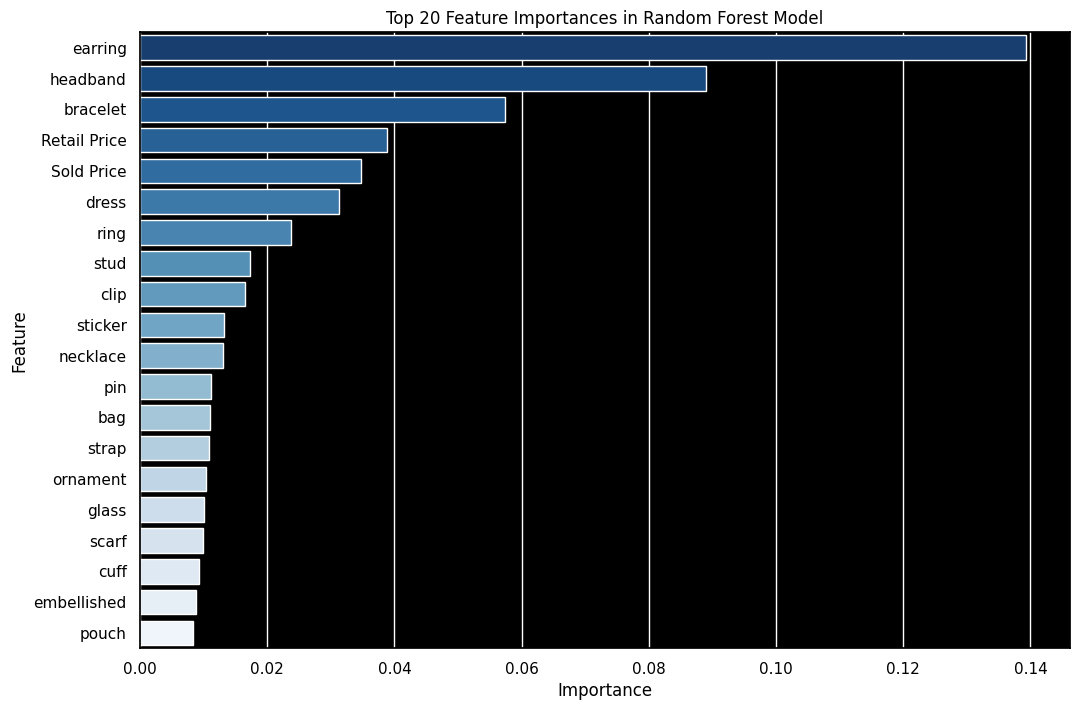

In [75]:
##best feature chart

import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame for the feature importances
feature_names = X.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid')
plt.style.use('dark_background')
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20), palette='Blues_r')
plt.title('Top 20 Feature Importances in Random Forest Model', color='black')
plt.xlabel('Importance', color='black')
plt.ylabel('Feature', color='black')

# Customize the appearance of the plot
ax.tick_params(colors='black')  # Set color of the tick labels
ax.yaxis.label.set_color('black')  # Set the y-axis label color
ax.xaxis.label.set_color('black')  # Set the x-axis label color
plt.setp(ax.get_xticklabels(), color='black')  # Set x-tick labels color
plt.setp(ax.get_yticklabels(), color='black')  # Set y-tick labels color
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.show()


## writing model to local drive

In [76]:
## writing model to local drive

from google.colab import drive
drive.mount('/content/drive')

import joblib

# Assuming tfidf_vectorizer is the vectorizer used during model training
joblib.dump(tfidf_vectorizer, '/content/drive/My Drive/Bexa/tfidf_vectorizer_item_type.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/My Drive/Bexa/tfidf_vectorizer_item_type.pkl']

##load the file - for use later



In [77]:
##load the file - for use later

import joblib

# Load the saved TF-IDF vectorizer
tfidf_vectorizer = joblib.load('/content/drive/My Drive/Bexa/tfidf_vectorizer_item_type.pkl')

## run with optimized paramters - writing best model to outputs


In [ ]:
## run with optimized paramters - writing best model to outputs


# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Mount Google Drive
drive.mount('/content/drive')

# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)


# Apply preprocessing to the 'Description' column
data_cleaned['Description'] = data_cleaned['Description'].apply(preprocess_text)

# Load the saved TF-IDF vectorizer
tfidf_vectorizer = joblib.load('/content/drive/My Drive/Bexa/tfidf_vectorizer_item_type.pkl')

# Define the Random Forest classifier with the optimized parameters
rf_classifier = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=100, random_state=42)

# Define the pipeline with the optimized parameters
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', rf_classifier)
])

# Fit the pipeline with the training data (if you have a training set)
# Split the data into training and testing sets (update this if you have training data available)
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['Description'], data_cleaned['Type'], test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# Save the pipeline to Google Drive
joblib.dump(pipeline,'/content/drive/My Drive/Bexa/best_model_type.pkl')


# Load the pipeline (if needed)
pipeline = joblib.load('/content/drive/My Drive/Bexa/best_model_type.pkl')

# Transform the 'Description' column using the fitted TF-IDF vectorizer
X_accumulated_tfidf = tfidf_vectorizer.transform(data_cleaned['Description'])

# Make predictions on the new data
data_cleaned['Predicted_Type'] = pipeline.predict(data_cleaned['Description'])

# Calculate prediction probabilities
pred_probabilities = pipeline.predict_proba(data_cleaned['Description'])

# Get the maximum probability for each prediction
max_probabilities = pred_probabilities.max(axis=1)

# Add the probabilities to the DataFrame
data_cleaned['Type_prediction_probability'] = max_probabilities

# Display the first 20 rows of the output with the new predicted_category and probability columns
print(data_cleaned[['Description', 'Predicted_Type', 'Type_prediction_probability']].head(20))


##write to file on google sheets

In [ ]:
##write to file on google sheets

# Assuming 'y_train' is a Series, convert it to a DataFrame for easier handling
data_cleaned = data_cleaned.astype(str)

# Convert the DataFrame to a list of lists
data = [data_cleaned.columns.values.tolist()] + data_cleaned.values.tolist()

# Create a new Google Sheet or open an existing one
spreadsheet_name = 'painted_tree_ml_training'
worksheet_name = 'Painted Tree - Training Model input - with Category and Type'

# Try to open the existing spreadsheet
try:
    spreadsheet = gc.open(spreadsheet_name)
except gspread.SpreadsheetNotFound:
    spreadsheet = gc.create(spreadsheet_name)

# Check if the worksheet already exists and delete it if it does
try:
    worksheet = spreadsheet.worksheet(worksheet_name)
    spreadsheet.del_worksheet(worksheet)
except gspread.WorksheetNotFound:
    pass

# Add a new worksheet
worksheet = spreadsheet.add_worksheet(title=worksheet_name, rows=len(data_cleaned)+1, cols=len(data_cleaned.columns))
#worksheet = spreadsheet.add_worksheet(title=worksheet_name, rows=len(y_train_df)+1, cols=len(y_train_df.columns))

# Write data to the worksheet
worksheet.update('A1', data)

#do 'theme' training and review.  Then get org and copy, make that the write to the new file post 3 NLP attempts.  Write it to file and reivew.  Then take orginal copy and make it into the visual, look at visuals.  Then have process for review.

#Train Data - Item 'Theme'

##get data from training on type - needs to have 'Category Run'

In [ ]:
gc  = gspread.authorize(creds)

# Function to read data from a Google Sheet and add a store location column
def read_sheet(url, worksheet_name, location):
    gsheets = gc.open_by_url(url)
    sheets = gsheets.worksheet(worksheet_name).get_all_values()
    df = pd.DataFrame(sheets[1:], columns=sheets[0])
    df['store_location'] = location
    return df

# URLs and worksheet names
kentucky_url = 'https://docs.google.com/spreadsheets/d/117PfZR2st0KhQ1L4t3GuNL7vsj2CYq6MDJhMm-cr6N4/edit?gid=427915297#gid=427915297'
cincinnati_url = 'https://docs.google.com/spreadsheets/d/1r_xXGRpcoegezaQTwpoOXhgaWpbHZIJYDoVnygquSGQ'
kentucky_sheet = 'Consignor Access - Activity (10)'
cincinnati_sheet = 'Consignor Access - Activity (11)'

# Read data from both sheets
kentucky_data = read_sheet(kentucky_url, kentucky_sheet, 'Kentucky')
cincinnati_data = read_sheet(cincinnati_url, cincinnati_sheet, 'Cincinnati')

# Combine the data into one DataFrame
combined_historical_data = pd.concat([kentucky_data, cincinnati_data], ignore_index=True)

# Filter out rows where 'Retail Price' is NA, NULL, or an empty string
combined_historical_data = combined_historical_data[combined_historical_data['Retail Price'].notna() & (combined_historical_data['Retail Price'] != '')]

# Remove rows where 'Category' is NA, NULL, or an empty string
combined_historical_data = combined_historical_data.dropna(subset=['Category'])
combined_historical_data = combined_historical_data[combined_historical_data['Category'] != '']

# Filter out rows where 'Retail Price' has a value of 'Retail Price'
combined_historical_data = combined_historical_data[combined_historical_data['Retail Price'] != 'Retail Price']

# Display the first few rows and get the column names and data types
print(combined_historical_data.info())
print(combined_historical_data.head())


##Clean Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import joblib


# Load the dataset
new_sales_data = combined_historical_data

# Clean and convert price columns to numerical values
def clean_price(price):
    if isinstance(price, str):
        price = price.replace('(', '').replace(')', '').replace('$', '').replace(',', '')
        try:
            return float(price)
        except ValueError:
            return None
    return price

new_sales_data['Retail Price'] = new_sales_data['Retail Price'].apply(clean_price)
new_sales_data['Sold Price'] = new_sales_data['Sold Price'].apply(clean_price)
new_sales_data['Store Amount'] = new_sales_data['Store Amount'].apply(clean_price)
new_sales_data['Consignor Amount'] = new_sales_data['Consignor Amount'].apply(clean_price)

# Drop rows with missing values in the target column 'Category', 'Type', 'Theme'
new_sales_data = new_sales_data.dropna(subset=['Category'])
new_sales_data = new_sales_data.dropna(subset=['Type'])
new_sales_data = new_sales_data.dropna(subset=['Theme'])
#Eliminates historical rows where the was a return
new_sales_data = new_sales_data[(new_sales_data['Sold Price'] >= 0) #&
                                #(new_sales_data['Store Amount'] >= 0) &
                                #(new_sales_data['Consignor Amount'] >= 0)
                                ]


# Clean up the 'Category' column
new_sales_data['Category'] = new_sales_data['Category'].str.upper()
new_sales_data['Type'] = new_sales_data['Type'].str.upper()
new_sales_data['Theme'] = new_sales_data['Theme'].str.upper()

# Make specified updates to the 'Category' column
category_updates = {
    'MISC': 'MISCELLANEOUS',
    'SHELL': 'DECOR',
    'CLOTHES': 'CLOTHING',
    'HAT': 'HATS',
    'APPAREL': 'CLOTHING',
    'DECOR - EASTER': 'DECOR',
    'DECOR - VALENTINES': 'DECOR',
    'DOGS': 'PET',
    'HAIR ACCESSORIES': 'ACCESSORIES: HAIR',
    'HOLIDAY - EASTER': 'DECOR',
    'HOLIDAY DECOR - EASTER': 'DECOR',
    'HOME KITCHEN': 'HOME',
    'KIDS': 'KIDS ACCESSORIES',
    'KIDS APPAREL': 'KIDS CLOTHING',
    'KIDS HAIR': 'KIDS ACCESSORIES',
    'KIDS HAT': 'KIDS ACCESSORIES',
    'KIDS HATS': 'KIDS ACCESSORIES',
    'KIDS JEWELRY': 'KIDS ACCESSORIES'
}

type_updates = {

    'BUNNY': 'BUNNY DECOR',
    'COAT': 'JACKET',
    'COVER UP': 'COVERUP',
    'COWBOY HAT': 'COWBOY',
    'COWBOY HAT DECOR': 'COWBOY',
    'DOG COLLAR LARGE': 'DOG COLLAR',
    'DOG COLLAR MEDIUM': 'DOG COLLAR',
    'DOG COLLAR SMALL' : 'DOG COLLAR',
    'EAR MUFFS': 'EARMUFFS',
    'HAIR CLIP': 'HAIR CLIPS',
    'KEY CHAIN': 'KEYCHAIN',
    'ORNAMENT': 'ORNAMENTS',
    'WINTER HAT': 'WINTER',
    'WINE TUMBLER': 'TUMBLER',
    'TOTE': 'TOTE BAG',
    'SWIM': 'SWIMWEAR',
    'RING': 'RINGS',
    'BEADED NECKLACE': 'NECKLACE',
    'BOTTLE OPENER':'MISCELLANEOUS' ,
    'SPPONS': 'SPOONS',
    'SPOON HOLDER':'SPOONS'

}

theme_updates = {
    'ANIMAL PRINT': 'ANIMALS',
    'ART DECO': 'ART',
    'EMBELLISHED DENIM': 'EMBELLISHED',
    'FLOWER': 'FLORAL',
    'FLOWERS': 'FLORAL',
    'HORSE': 'HORSES',
    'MOTHERS DAY': 'MOM',
    'MUSHROOM': 'MUSHROOMS',
    'PLANTS': 'PLANT',
    'RHINESTONE': 'RHINESTONES',
    'SELF ESTEEM': 'SELF CARE',
    'ST. PATRICKS':    'ST PATRICKS DAY',
    'ST.PATRICKS DAY': 'ST PATRICKS DAY',
    'SWIFTIE': 'TAYLOR SWIFT',
    'TIGER':'TIGER/BENGALS',
    'BENGALS': 'TIGER/BENGALS',
    'VALENTINE''S DAY':'VALENTINES',
    'VALENTINE': 'VALENTINES',
    'WINTER COAT':'WINTER',
    'WESTER':'WESTERN'
}

new_sales_data['Category'] = new_sales_data['Category'].replace(category_updates)
new_sales_data['Type'] = new_sales_data['Type'].replace(type_updates)
new_sales_data['Theme'] = new_sales_data['Theme'].replace(theme_updates)

# Drop columns 'Type' and 'Theme' as they will not be used for prediction
#data_cleaned = new_sales_data.drop(columns=[ 'Theme'])
data_cleaned = new_sales_data

new_sales_data

## first pass on random forest model

In [ ]:

# Vectorize the 'Description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Description'])

# Create a DataFrame from the TF-IDF features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add other numerical features to the TF-IDF DataFrame
X = pd.concat([X_tfidf_df, data_cleaned[['Retail Price', 'Sold Price']].reset_index(drop=True)], axis=1)

# Encode the target variable 'Category'
y = data_cleaned['Theme']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

accuracy_rf, report_rf

##NLP and tuning on Description field as input to prediction variable

In [ ]:
##NLP and tuning on Description field as input to prediction variable

from sklearn.model_selection import GridSearchCV

# Vectorize the 'Description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Description'])

# Create a DataFrame from the TF-IDF features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add other numerical features to the TF-IDF DataFrame
X = pd.concat([X_tfidf_df, data_cleaned[['Retail Price', 'Sold Price']].reset_index(drop=True)], axis=1)

# Encode the target variable 'Theme'
y = data_cleaned['Theme']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Initialize the GridSearchCV with Random Forest model
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the best model with best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the model's performance
best_accuracy = accuracy_score(y_test, y_pred_best)
best_report = classification_report(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Test Set Accuracy:", best_accuracy)
print("Classification Report:\n", best_report)

## best parameters for hyper tuning

In [ ]:
## best parameters for hyper tuning

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

# Apply preprocessing to the 'Description' column
data_cleaned['Description'] = data_cleaned['Description'].apply(preprocess_text)

# Define a TF-IDF vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(max_features=500, max_df=0.95, min_df=5, ngram_range=(1, 2))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['Description'], data_cleaned['Theme'], test_size=0.2, random_state=42)

# Define a pipeline with TF-IDF vectorizer and Random Forest classifier
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define a parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_df': [0.85, 0.9, 0.95],
    'tfidf__min_df': [3, 5, 7],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

# Perform GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Add the predictions and prediction probabilities to the original DataFrame
data_cleaned['Predicted_Theme'] = grid_search.predict(data_cleaned['Description'])
pred_probabilities = grid_search.predict_proba(data_cleaned['Description'])
max_probabilities = pred_probabilities.max(axis=1)
data_cleaned['Theme_prediction_probability'] = max_probabilities

# Display the first 20 rows of the output
print(data_cleaned[['Description', 'Predicted_Theme', 'Theme_prediction_probability']].head(20))

##run with Best NLP parameters

In [ ]:
##run with Best NLP parameters
best_nlp_params = {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'tfidf__max_df': 0.85, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}


#tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features for simplicity
# Define a TF-IDF vectorizer with optimized parameters
#{'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'tfidf__max_df': 0.85, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
# Vectorize the 'Description' column using TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.85,
    min_df=5,
    ngram_range=(1, 1),
    max_features=500  # Optionally retain the feature limit if required
)

X_tfidf = tfidf_vectorizer.fit_transform(data_cleaned['Description'])

# Create a DataFrame from the TF-IDF features
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add other numerical features to the TF-IDF DataFrame
X = pd.concat([X_tfidf_df, data_cleaned[['Retail Price', 'Sold Price']].reset_index(drop=True)], axis=1)

# Encode the target variable 'Theme'
y = data_cleaned['Theme']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the best parameters found by GridSearchCV
#best_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
best_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators':200}

# Initialize the Random Forest model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)

# Train the model
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the model's performance
best_accuracy = accuracy_score(y_test, y_pred_best)
best_report = classification_report(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("Test Set Accuracy:", best_accuracy)
print("Classification Report:\n", best_report)

##best feature chart


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame for the feature importances
feature_names = X.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.set(style='whitegrid')  # Set seaborn style to whitegrid
plt.style.use('seaborn-whitegrid')  # Ensure the entire background is white
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(20), palette='Blues_r')

# Customize the plot appearance
ax.set_title('Top 20 Feature Importances in Random Forest Model', color='black')
ax.set_xlabel('Importance', color='white')
ax.set_ylabel('Feature', color='black')

# Set the background color of the plot area
ax.set_facecolor('white')

# Set the tick labels and axes labels color
ax.tick_params(colors='black')
plt.setp(ax.get_xticklabels(), color='black')
plt.setp(ax.get_yticklabels(), color='black')

# Remove the spines (borders) to ensure the background is fully white
sns.despine(left=True, bottom=True)

plt.show()



## writing model to local drive

In [ ]:
## writing model to local drive

from google.colab import drive
drive.mount('/content/drive')

import joblib

# Assuming tfidf_vectorizer is the vectorizer used during model training
joblib.dump(tfidf_vectorizer, '/content/drive/My Drive/Bexa/tfidf_vectorizer_item_theme.pkl')

##load the file - for use later

In [ ]:
##load the file - for use later

import joblib

# Load the saved TF-IDF vectorizer
tfidf_vectorizer = joblib.load('/content/drive/My Drive/Bexa/tfidf_vectorizer_item_theme.pkl')

## run with optimized parameters - writing best model to outputs


In [ ]:
## run with optimized parameters - writing best model to outputs


# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Mount Google Drive
drive.mount('/content/drive')

# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)


# Apply preprocessing to the 'Description' column
data_cleaned['Description'] = data_cleaned['Description'].apply(preprocess_text)

# Load the saved TF-IDF vectorizer
tfidf_vectorizer = joblib.load('/content/drive/My Drive/Bexa/tfidf_vectorizer_item_theme.pkl')

# Define the Random Forest classifier with the optimized parameters
rf_classifier = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=100, random_state=42)

# Define the pipeline with the optimized parameters
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', rf_classifier)
])

# Fit the pipeline with the training data (if you have a training set)
# Split the data into training and testing sets (update this if you have training data available)
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['Description'], data_cleaned['Theme'], test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# Save the pipeline to Google Drive
joblib.dump(pipeline,'/content/drive/My Drive/Bexa/best_model_theme.pkl')


# Load the pipeline (if needed)
pipeline = joblib.load('/content/drive/My Drive/Bexa/best_model_theme.pkl')

# Transform the 'Description' column using the fitted TF-IDF vectorizer
X_accumulated_tfidf = tfidf_vectorizer.transform(data_cleaned['Description'])

# Make predictions on the new data
data_cleaned['Predicted_Theme'] = pipeline.predict(data_cleaned['Description'])

# Calculate prediction probabilities
pred_probabilities = pipeline.predict_proba(data_cleaned['Description'])

# Get the maximum probability for each prediction
max_probabilities = pred_probabilities.max(axis=1)

# Add the probabilities to the DataFrame
data_cleaned['Theme_prediction_probability'] = max_probabilities

# Display the first 20 rows of the output with the new predicted_category and probability columns
print(data_cleaned[['Description', 'Predicted_Theme', 'Theme_prediction_probability']].head(20))


##write to file on google sheets

In [ ]:
##write to file on google sheets

# Assuming 'y_train' is a Series, convert it to a DataFrame for easier handling
data_cleaned = data_cleaned.astype(str)

# Convert the DataFrame to a list of lists
data = [data_cleaned.columns.values.tolist()] + data_cleaned.values.tolist()

# Create a new Google Sheet or open an existing one
spreadsheet_name = 'painted_tree_ml_training'
worksheet_name = 'Painted Tree - Training Model input - with Category and Type and Theme'

# Try to open the existing spreadsheet
try:
    spreadsheet = gc.open(spreadsheet_name)
except gspread.SpreadsheetNotFound:
    spreadsheet = gc.create(spreadsheet_name)

# Check if the worksheet already exists and delete it if it does
try:
    worksheet = spreadsheet.worksheet(worksheet_name)
    spreadsheet.del_worksheet(worksheet)
except gspread.WorksheetNotFound:
    pass

# Add a new worksheet
worksheet = spreadsheet.add_worksheet(title=worksheet_name, rows=len(data_cleaned)+1, cols=len(data_cleaned.columns))
#worksheet = spreadsheet.add_worksheet(title=worksheet_name, rows=len(y_train_df)+1, cols=len(y_train_df.columns))

# Write data to the worksheet
worksheet.update('A1', data)